<img src="../images/QISKit-c.gif" alt="Note: In order for images to show up in this jupyter notebook you need to select File => Trusted Notebook" width="250 px" align="left">

## *Quantum_chemistry*



## Introduction


In [1]:
# Checking the version of PYTHON; we only support 3 at the moment
import sys
if sys.version_info < (3,0):
    raise Exception("Please use Python version 3 or greater.")
    
    
# useful additional packages 
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from scipy import linalg as la
import matplotlib.pyplot as plt

import sys
sys.path.append("../../")
# importing the QISKit
from qiskit import QuantumCircuit, QuantumProgram
import Qconfig
import math

# import basic plot tools
from qiskit.basicplotter import plot_histogram

# import optimization tools
from tools.optimizationtools import trial_circuit_pauli,trial_funtion_optimization, SPSA_optimization
from tools.optimizationtools import cost_function, make_Hamiltonian, parse_hamiltonian_file, text_to_ham
from functools import partial


Hamtext=parse_hamiltonian_file("H2Equilibrium.txt")

In [2]:
def eval_hamiltonian(n,m,file_name,device,shots,theta):


    ham_array=parse_hamiltonian_file(file_name);
    
    avg_energy=0
    var_energy=0
    std_energy=0
    
    
    circuits=[]
    trial_circuit=[]
    
    Q_program = QuantumProgram()
    Q_program.set_api(Qconfig.APItoken,Qconfig.config["url"])
    
    
    # STACK QUANTUM CIRCUITS ASSOCIATED TO EACH PAULI TERM AND EXECUTE THEM 
    
    for i in range(math.ceil(len(ham_array)/2)):     


        trial_circuit.append(trial_circuit_pauli(n,m,theta,entangler_map,ham_array[i*2]))
        circuits.append("trial_circuit_label"+str(i))
        Q_program.add_circuit(circuits[i],trial_circuit[i])
        
        
    # EXECUTE THE CIRCUITS STACKED 
    Q_program.execute(circuits,device,shots)
    
    
    # COMPUTE MEAN ENERGY AND STANDARD ERROR ASSOCIATED TO EACH PAULI TERM AND THEN SUM THEM INTO AVG_ENERGY
    
    pauli_energy=np.zeros(math.ceil(len(ham_array)/2))
    pauli_var=np.zeros(math.ceil(len(ham_array)/2))

    
    for i in range(math.ceil(len(ham_array)/2)):#loop over Pauli terms
       
        countsloop=Q_program.get_counts(circuits[i])
        #print(countsloop)
        
            
        for j in countsloop:  #loop over counts of a Pauli measurement outcome
            pauli_avg_count=float(ham_array[2*i+1])
            for k in range(n):  # loop over qubits 
                
                if ham_array[2*i][k]!='I' and j[(n-1)-k]=="1":
                    pauli_avg_count=-pauli_avg_count # put minus sign on given counts of given Pauli
            
            pauli_energy[i]+=pauli_avg_count*countsloop[j]/shots
           
        for j in countsloop:  #loop over counts of a Pauli measurement outcome
            pauli_avg_count=float(ham_array[2*i+1])
            for k in range(n):  # loop over qubits 
                
                if ham_array[2*i][k]!='I' and j[(n-1)-k]=="1":
                    pauli_avg_count=-pauli_avg_count # put minus sign on given counts of given Pauli
            
            pauli_var[i]+=countsloop[j]*math.pow((pauli_avg_count-pauli_energy[i]),2)/(shots-1)
        
   

    
    for i in range(math.ceil(len(ham_array)/2)): 
        avg_energy+=pauli_energy[i]
        var_energy+=pauli_var[i]
        
        
    std_energy=np.sqrt(var_energy)/np.sqrt(shots)
    
    
    
    
    
    return avg_energy,std_energy
                        

## Optimization of H2 at bond length

In [33]:
n=2
m=2
device='ibmqx2'
SPSA_params=[1,.1,.602,.101,0]
theta=np.zeros(2*n*m)
entangler_map={0: [1]} # the map of two-qubit gates with control at key and target at values
shots=1000
max_trials=35

#Exact Energy
text_to_ham('H2Equilibrium.txt')
eigen=la.eig(text_to_ham('H2Equilibrium.txt'))
exact=np.amin(eigen[0])
        
# Optimization
eval_hamiltonian_partial=partial(eval_hamiltonian,n,m,'H2Equilibrium.txt',device,shots)
output=SPSA_optimization(eval_hamiltonian_partial,theta,SPSA_params,max_trials);
plt.plot(output[1],label='E(theta_plus)')
plt.plot(output[2],label='E(theta_minus)')
plt.plot(np.ones(max_trials)*output[0],label='Final Energy')
plt.plot(np.ones(max_trials)*exact,label='Exact Energy')
plt.legend()

running on backend: ibmqx2
status = RUNNING (5 seconds)
status = RUNNING (10 seconds)
status = RUNNING (15 seconds)
status = RUNNING (20 seconds)


KeyboardInterrupt: 

## Optimizing the potential energy surface 

/Users/amezzac/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:56: ComplexWarning: Casting complex values to real discards the imaginary part


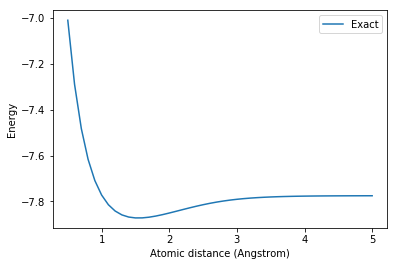

In [24]:
# MOLECULE PARAMETERS

molecule='LiH' #name of the molecule: options are H2 or LiH

if molecule=='H2':
    n=2 # qubits
    Z1=1
    Z2=1
    min_distance=.2
    max_distance=4
    number_of_points=39
elif molecule=='LiH':
    n=4 # qubits
    Z1=1
    Z2=3
    min_distance=.5
    max_distance=5
    number_of_points=46
    
    
# OPTIMIZATION PARAMETERS 

run_optimization='No' # Choose 'Yes' or 'No'

m=2 # depth (number of layers of sq gates - # entanglers is this number -1)
device='local_qasm_simulator'
theta=np.zeros(2*n*m)  # initial angles 
entangler_map={0: [1]} # the map of two-qubit gates with control at key and target at values
shots=1000
max_trials=1
SPSA_params=[1,.1,.602,.101,0]



####################     COMPUTING FOR THE POTENTIAL ENERGY SURFACE      ###################

mol_distance=np.zeros(number_of_points)
coulomb_repulsion=np.zeros(number_of_points)
electr_energy=np.zeros(number_of_points)
electr_energy_optimized=np.zeros(number_of_points)

for i in range(number_of_points):

    
    # %%%%%%%%%%%%% Coulomb Repulsion For Diatomic molecules %%%%%%%%%%%%%%%%%%%%%%
        mol_distance[i]=np.around((min_distance+(max_distance-min_distance)*i/(number_of_points-1)),2)
        #print(mol_distance)
        distance=mol_distance[i]/0.529177
        coulomb_repulsion[i]=Z1*Z2/distance
        
    # exact diagonalization
        ham_text=molecule+'/PESMap'+str(i)+'atdistance'+str(mol_distance[i])+'.txt'
        text_to_ham(ham_text)
        eigen=la.eig(text_to_ham(ham_text))
        electr_energy[i]=np.amin(eigen[0])
        
    # optimization
    
        if run_optimization=='Yes':
            print('\nOPTIMIZING HAMILTONIAN # '+str(i)+' AT INTERATOMIC DISTANCE '+str(mol_distance)+' ANGSTROM\n')
            eval_hamiltonian_partial=partial(eval_hamiltonian,n,m,ham_text,device,shots)
            electr_energy_optimized[i]=SPSA_optimization(eval_hamiltonian_partial,theta,SPSA_params,max_trials)[0]
            plt.plot(electr_energy_optimized+coulomb_repulsion,label='Optimized') 


plt.plot(mol_distance,electr_energy+coulomb_repulsion,label='Exact')
plt.xlabel('Atomic distance (Angstrom)')
plt.ylabel('Energy')
plt.legend()
        